# Comparing Support Vector Machines, Decision Trees and Naive Bayes for Heart Failure Prediction

Notebook for workshop assignment [Workshop: Compare Support Vector Machines to DTs and NB](https://hiof.instructure.com/courses/8923/assignments/41776?module_item_id=283971)

In [82]:
# Notebook for Workshop: Compare Support Vector Machines, DTs and NB
# https://hiof.instructure.com/courses/8923/assignments/41776?module_item_id=283971

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV

In [83]:
pd.set_option("display.max_columns", None)

I've added some markdown cells that provide some tips into how to discuss results. Note that my comments were made to a
particular run. Due the limitations with setup related to random sampling, we get different results each time we run. The discussions might therefore be slightly errornous when discussion concrete numbers, but they still provide valuable tips for how to discuss results.

In [84]:
# Load the dataset and show first 5 rows

dataset = pd.read_csv('../data/heart_failure/heart_failure_clinical_records_dataset.csv')
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Exploratory Analysis and Processing

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'anaemia'}>,
        <Axes: title={'center': 'creatinine_phosphokinase'}>,
        <Axes: title={'center': 'diabetes'}>],
       [<Axes: title={'center': 'ejection_fraction'}>,
        <Axes: title={'center': 'high_blood_pressure'}>,
        <Axes: title={'center': 'platelets'}>,
        <Axes: title={'center': 'serum_creatinine'}>],
       [<Axes: title={'center': 'serum_sodium'}>,
        <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'smoking'}>,
        <Axes: title={'center': 'time'}>],
       [<Axes: title={'center': 'DEATH_EVENT'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

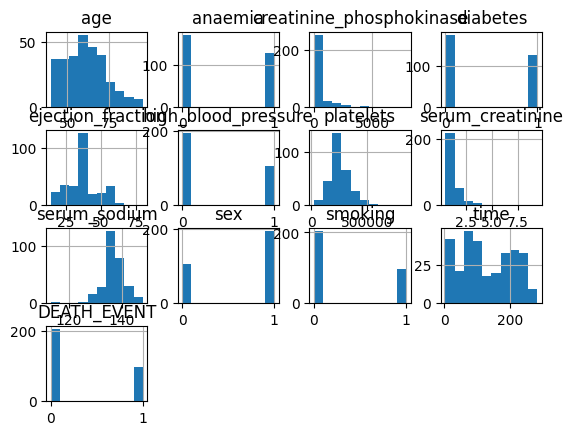

In [85]:
# Show the distribution of all the columns (both features and targets). We do this 
# to explore our data so that we better know how to proceed with the training. 
# This should be improved.

dataset.hist()

We did this analysis to determine which version of naive bayes to use. We can see that some of the features are what we can consider normally distributed and some are binary. The normally distributed features aren't necessarily bell shaped like we would expect for normally distributed data, but they are closer to normally distributed than the alternative (binary/frequency).

The fact that we have two different types of distributions in our features means that we might have to create a custom classifier that combines a gaussian and bernoulli classifier to achieve optimal performance.

## Training & Tuning

In [86]:
# Split into 60/20/20. 60% for training, 20% validation, and 20% for final testing

trainval = dataset.groupby('DEATH_EVENT', group_keys=False)[dataset.columns].apply(lambda x: x.sample(frac=0.8))
test = dataset.drop(trainval.index)

In [87]:
# Separate input features from targets in all partitions

trainval_features = trainval.drop('DEATH_EVENT', axis=1)
trainval_targets = trainval['DEATH_EVENT']

test_features = test.drop('DEATH_EVENT', axis=1)
test_targets = test.DEATH_EVENT

In [88]:
# A custom function for evaluation the performance using accuracy, precision, recall, f1 and roc_auc
def evaluate(model):

    # Store the prediction probabilites and the predictions. We need the probabilities for 
    # roc_auc_score metric

    train_probabilities = model.predict_proba(trainval_features)
    # train_predictions = model.predict(train_features)
    # This does the same as the statement above without having the model predict again
    train_predictions = model.classes_.take(np.argmax(train_probabilities, axis=1), axis=0)

    # Print the training and validation scores

    print(f'Training Accuracy: {accuracy_score(trainval_targets, train_predictions)}')
    print(f'Training Precision: {precision_score(trainval_targets, train_predictions)}')
    print(f'Training Recall: {recall_score(trainval_targets, train_predictions)}')
    print(f'Training F1: {f1_score(trainval_targets, train_predictions)}')
    print(f'Training ROC AUC: {roc_auc_score(trainval_targets, train_probabilities[:,1])}')
    
    # Evaluate and print the final test scores     

    test_probabilities = model.predict_proba(test_features)
    test_predictions = model.classes_.take(np.argmax(test_probabilities, axis=1), axis=0)

    print(f'Test Accuracy: {accuracy_score(test_targets, test_predictions)}')
    print(f'Test Precision: {precision_score(test_targets, test_predictions)}')
    print(f'Test Recall: {recall_score(test_targets, test_predictions)}')
    print(f'Test F1: {f1_score(test_targets, test_predictions)}')
    print(f'Test ROC AUC: {roc_auc_score(test_targets, test_probabilities[:,1])}')
    print()

In [89]:
def show_cv_results(cv_results):
    sorted_results = cv_results.sort_values('rank_test_f1',ascending=False)
    return sorted_results[['mean_train_f1', 'mean_train_precision', 'mean_train_recall', 'mean_train_accuracy', 'mean_train_roc_auc', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall', 'mean_test_accuracy', 'mean_test_roc_auc']].iloc[0]

In [90]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [91]:
# Train a decision tree using grid search

dt_params = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': range(1,21)
    # Needs to be expanded with more parameters
}
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, scoring=metrics, refit='f1',return_train_score=True)

dt_grid.fit(trainval_features, trainval_targets)

dt_cv_results = pd.DataFrame(dt_grid.cv_results_)
dt_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.002309,0.000251,0.009816,0.001533,gini,1,"{'criterion': 'gini', 'max_depth': 1}",0.937500,0.729167,0.854167,0.833333,0.787234,0.828280,0.069474,1,0.816754,0.858639,0.837696,0.842932,0.854167,0.842038,0.014708,1.000000,0.600000,0.846154,0.900000,0.777778,0.824786,0.133830,1,0.800000,0.906977,0.840909,0.829787,0.854167,0.846368,0.035182,0.800000,0.400000,0.6875,0.5625,0.466667,0.583333,0.145225,39,0.580645,0.629032,0.606557,0.639344,0.661290,0.623374,0.027688,0.888889,0.480000,0.758621,0.692308,0.583333,0.680630,0.140932,3,0.672897,0.742857,0.704762,0.722222,0.745455,0.717639,0.026827,0.900000,0.639394,0.812500,0.765625,0.702083,0.763920,0.089679,8,0.755439,0.799012,0.776356,0.788903,0.803722,0.784686,0.017379
1,0.002292,0.000163,0.009326,0.000274,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.895833,0.729167,0.812500,0.833333,0.765957,0.807358,0.057196,3,0.821990,0.869110,0.842932,0.842932,0.869792,0.849351,0.018107,0.812500,0.555556,0.652174,0.900000,0.625000,0.709046,0.127298,4,0.679487,0.776119,0.718310,0.829787,0.753425,0.751426,0.051041,0.866667,0.666667,0.9375,0.5625,0.666667,0.740000,0.139508,1,0.854839,0.838710,0.836066,0.639344,0.887097,0.811211,0.087834,0.838710,0.606061,0.769231,0.692308,0.645161,0.710294,0.084136,1,0.757143,0.806202,0.772727,0.722222,0.814815,0.774622,0.033668,0.924242,0.720202,0.899414,0.781250,0.762500,0.817522,0.079887,1,0.866529,0.888660,0.875851,0.880013,0.900062,0.882223,0.011414
2,0.002305,0.000144,0.009041,0.000455,gini,3,"{'criterion': 'gini', 'max_depth': 3}",0.895833,0.729167,0.791667,0.770833,0.744681,0.786436,0.058757,5,0.874346,0.900524,0.879581,0.890052,0.906250,0.890151,0.012069,0.916667,0.555556,0.687500,0.727273,0.600000,0.697399,0.125439,6,0.865385,0.852459,0.865385,0.833333,0.854839,0.854280,0.011739,0.733333,0.666667,0.6875,0.5000,0.600000,0.637500,0.081052,31,0.725806,0.838710,0.737705,0.819672,0.854839,0.795346,0.053235,0.814815,0.606061,0.687500,0.592593,0.600000,0.660194,0.084589,10,0.789474,0.845528,0.796460,0.826446,0.854839,0.822549,0.025925,0.932323,0.788889,0.843750,0.768555,0.721875,0.811078,0.072147,3,0.914416,0.935484,0.927869,0.928689,0.923883,0.926068,0.006918
3,0.002243,0.000054,0.008779,0.000157,gini,4,"{'criterion': 'gini', 'max_depth': 4}",0.812500,0.729167,0.791667,0.812500,0.702128,0.769592,0.045509,16,0.921466,0.931937,0.910995,0.916230,0.932292,0.922584,0.008458,0.666667,0.555556,0.666667,0.818182,0.533333,0.648081,0.101344,11,0.873016,0.901639,0.923077

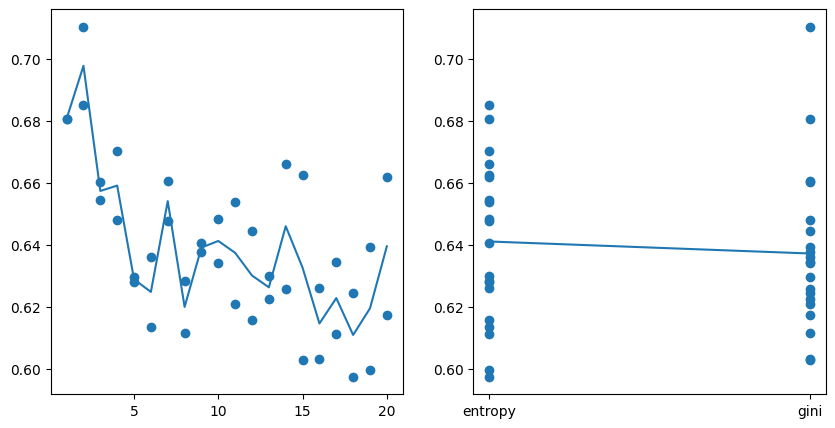

In [92]:
dt_param_scores = dt_cv_results[['param_max_depth', 'param_criterion', 'mean_test_f1']]

dt_max_depth = dt_param_scores.pivot_table(index='param_criterion', columns='param_max_depth', values='mean_test_f1')
dt_max_depth_means = dt_max_depth.mean(axis=0)

dt_criterion = dt_param_scores.pivot_table(index='param_max_depth', columns='param_criterion', values='mean_test_f1')
dt_criterion_means = dt_criterion.mean(axis=0)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(dt_max_depth_means.index, dt_max_depth_means)
ax[0].scatter(dt_cv_results['param_max_depth'], dt_cv_results['mean_test_f1'])
ax[1].plot(dt_criterion_means.index, dt_criterion_means)
ax[1].scatter(dt_cv_results['param_criterion'], dt_cv_results['mean_test_f1'])
plt.show()


In [93]:
show_cv_results(dt_cv_results)

mean_train_f1           1.000000
mean_train_precision    1.000000
mean_train_recall       1.000000
mean_train_accuracy     1.000000
mean_train_roc_auc      1.000000
mean_test_f1            0.597406
mean_test_precision     0.582913
mean_test_recall        0.620000
mean_test_accuracy      0.736170
mean_test_roc_auc       0.705076
Name: 37, dtype: float64

In [94]:
evaluate(dt_grid)

Training Accuracy: 0.8451882845188284
Training Precision: 0.7222222222222222
Training Recall: 0.8441558441558441
Training F1: 0.7784431137724551
Training ROC AUC: 0.8781064614397948
Test Accuracy: 0.7833333333333333
Test Precision: 0.6363636363636364
Test Recall: 0.7368421052631579
Test F1: 0.6829268292682927
Test ROC AUC: 0.8145057766367139



In [95]:
# Calculate the confusion matrix for the best decision tree model.

confusion_matrix(test_targets, dt_grid.predict(test_features))

array([[33,  8],
       [ 5, 14]])

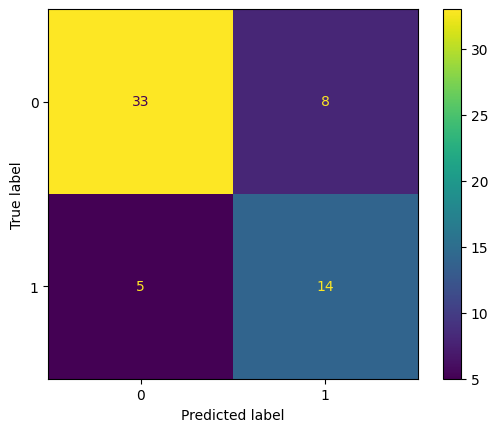

In [96]:
# The ConfusionMatrixDisplay class can be used to make confusion matrix plots

ConfusionMatrixDisplay.from_estimator(dt_grid, test_features, test_targets)

The confusion matrix show that dt2 is very accurate in it's predictions (precision), only two false positives. There are however 9 false negatives i.e. 9 failures that wasn't predicted. This could have dramatic consequences in practice.

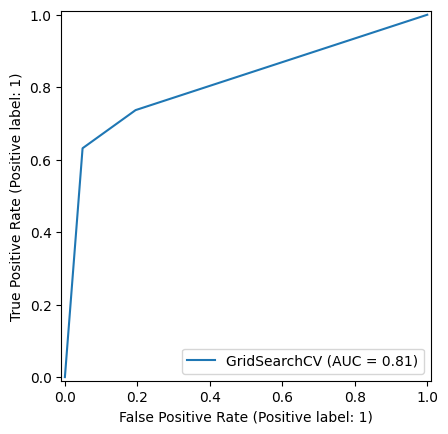

In [97]:
# Plot the ROC curve for the best decision tree model

# These two statements achieves the same thing
# RocCurveDisplay.from_predictions(test_targets, dt2.predict_proba(test_features)[:,1])
RocCurveDisplay.from_estimator(dt_grid, test_features, test_targets)

The ROC curve show very good performance for all sensitivities. This is also shown by the AUC of 0.84

In [98]:
# Train and evaluate a gaussian naive bayesian classifier with default parameters

nb_params = {
    'var_smoothing': np.logspace(-10, -5, 6)
}
print(1e-5)
nb_grid = GridSearchCV(GaussianNB(), nb_params, scoring=metrics, refit='f1')
nb_grid.fit(trainval_features, trainval_targets)
nb_cv_results = pd.DataFrame(nb_grid.cv_results_)
nb_cv_results

1e-05


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.002703,0.000395,0.010518,0.000859,1.000000e-10,{'var_smoothing': 1e-10},0.812500,0.770833,0.750000,0.750000,0.765957,0.769858,0.022905,2,0.875000,0.642857,0.700000,0.750000,0.700000,0.733571,0.078428,3,0.466667,0.600000,0.4375,0.3750,0.466667,0.469167,0.073485,4,0.608696,0.620690,0.538462,0.500000,0.560000,0.565569,0.044639,4,0.870707,0.795960,0.828125,0.929688,0.795833,0.844063,0.050864,1
1,0.002370,0.000475,0.010337,0.000695,1.000000e-09,{'var_smoothing': 1e-09},0.812500,0.750000,0.729167,0.791667,0.765957,0.769858,0.029527,3,0.875000,0.588235,0.636364,0.800000,0.750000,0.729920,0.105062,4,0.466667,0.666667,0.4375,0.5000,0.400000,0.494167,0.092331,2,0.608696,0.625000,0.518519,0.615385,0.521739,0.577868,0.047439,2,0.860606,0.787879,0.814453,0.902344,0.831250,0.839306,0.039382,2
2,0.002542,0.000506,0.010083,0.000592,1.000000e-08,{'var_smoothing': 1e-08},0.854167,0.687500,0.812500,0.750000,0.744681,0.769770,0.057857,4,0.900000,0.500000,0.818182,0.750000,0.714286,0.736494,0.134173,2,0.600000,0.600000,0.5625,0.3750,0.333333,0.494167,0.115878,1,0.720000,0.545455,0.666667,0.500000,0.454545,0.577333,0.100407,3,0.854545,0.751515,0.832031,0.892578,0.797917,0.825717,0.048208,3
3,0.002394,0.000231,0.010088,0.000558,1.000000e-07,{'var_smoothing': 1e-07},0.833333,0.708333,0.833333,0.750000,0.787234,0.782447,0.048471,1,0.888889,0.533333,0.833333,0.833333,0.777778,0.773333,0.125038,1,0.533333,0.533333,0.6250,0.3125,0.466667,0.494167,0.103870,2,0.666667,0.533333,0.714286,0.454545,0.583333,0.590433,0.092658,1,0.854545,0.723232,0.808594,0.878906,0.762500,0.805556,0.057307,4
4,0.002213,0.000201,0.010317,0.000501,1.000000e-06,{'var_smoothing': 1e-06},0.666667,0.625000,0.687500,0.666667,0.680851,0.665337,0.021737,5,0.000000,0.200000,1.000000,0.500000,0.500000,0.440000,0.338231,5,0.000000,0.066667,0.0625,0.0625,0.066667,0.051667,0.025900,5,0.000000,0.100000,0.117647,0.111111,0.117647,0.089281,0.045104,5,0.747475,0.628283,0.779297,0.800781,0.704167,0.732000,0.061220,5
5,0.002077,0.000146,0.009408,0.000560,1.000000e-05,{'var_smoothing': 1e-05},0.666667,0.625000,0.687500,0.666667,0.659574,0.661082,0.020320,6,0.000000,0.200000,1.000000,0.500000,0.333333,0.406667,0.338887,6,0.000000,0.066667,0.0625,0.0625,0.066667,0.051667,0.025900,5,0.000000,0.100000,0.117647,0.111111,0.111111,0.087974,0.044351,6,0.440404,0.472727,0.613281,0.601562,0.556250,0.536845,0.069021,6


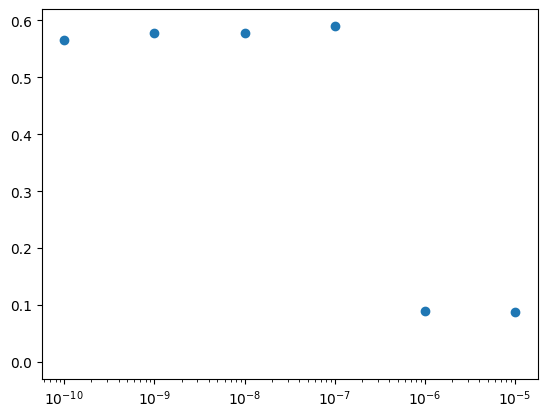

In [99]:
fig, ax = plt.subplots(1,1)
ax.semilogx(1e-10, 0)
plt.scatter(nb_cv_results['param_var_smoothing'], nb_cv_results['mean_test_f1'])

* The two models performs exactly the same on test data, which makes us have to fall back to validation data in determining which models is the best
* nb1 is the better of the two for validation data. (Individual metrics should be discussed)

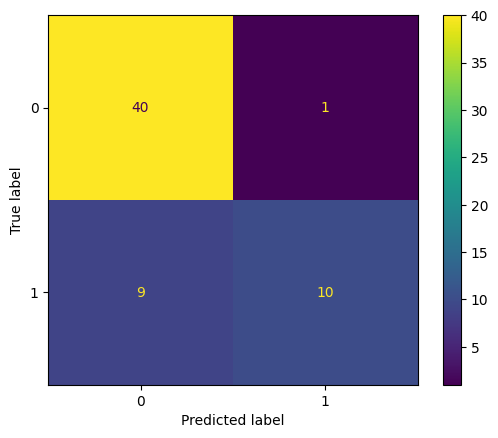

In [100]:
# Plot the confusion matrix for the best NB

ConfusionMatrixDisplay.from_estimator(nb_grid, test_features, test_targets)

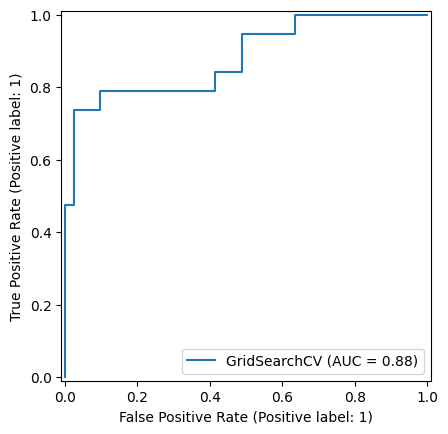

In [101]:
RocCurveDisplay.from_estimator(nb_grid, test_features, test_targets)

In [106]:
svc_params = {
    'C': [0.5, 1.0, 2.0, 4.0], 
    'kernel': ['rbf', 'poly', 'sigmoid']
}
svc_grid = GridSearchCV(SVC(probability=True), svc_params, scoring=metrics, refit='f1', return_train_score=True)
svc_grid.fit(trainval_features, trainval_targets)
svc_cv_results = pd.DataFrame(svc_grid.cv_results_)
svc_cv_results

/home/lars/.venv/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lars/.venv/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lars/.venv/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lars/.venv/ml/lib/python3.12/site-packag

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.011409,0.006574,0.011972,0.004004,0.5,rbf,"{'C': 0.5, 'kernel': 'rbf'}",0.687500,0.687500,0.666667,0.666667,0.680851,0.677837,0.009438,1,0.675393,0.675393,0.680628,0.680628,0.677083,0.677825,0.002371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.581818,0.404040,0.482422,0.429688,0.591667,0.497927,0.076859,8,0.546637,0.469867,0.604666,0.541236,0.564020,0.545285,0.043779
1,0.009792,0.004678,0.009517,0.000232,0.5,poly,"{'C': 0.5, 'kernel': 'poly'}",0.687500,0.687500,0.666667,0.666667,0.680851,0.677837,0.009438,1,0.675393,0.675393,0.680628,0.680628,0.677083,0.677825,0.002371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.450505,0.701010,0.423828,0.537109,0.643750,0.551241,0.107303,4,0.516254,0.775819,0.579697,0.581715,0.742308,0.639159,0.101249
2,0.009225,0.000361,0.009761,0.000383,0.5,sigmoid,"{'C': 0.5, 'kernel': 'sigmoid'}",0.687500,0.687500,0.666667,0.666667,0.680851,0.677837,0.009438,1,0.675393,0.675393,0.680628,0.680628,0.677083,0.677825,0.002371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.402020,0.416162,0.541016,0.505859,0.550000,0.483011,0.062294,10,0.508502,0.496499,0.469231,0.475914,0.472829,0.484595,0.015252
3,0.008929,0.000686,0.009654,0.000230,1.0,rbf,"{'C': 1.0, 'kernel': 'rbf'}",0.687500,0.687500,0.666667,0.666667,0.680851,0.677837,0.009438,1,0.675393,0.675393,0.680628,0.680628,0.677083,0.677825,0.002371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.0

In [108]:
show_cv_results(svc_cv_results)

mean_train_f1           0.000000
mean_train_precision    0.000000
mean_train_recall       0.000000
mean_train_accuracy     0.677825
mean_train_roc_auc      0.545285
mean_test_f1            0.000000
mean_test_precision     0.000000
mean_test_recall        0.000000
mean_test_accuracy      0.677837
mean_test_roc_auc       0.497927
Name: 0, dtype: float64

In [109]:
# Here you should add a collected presentation of all the results to make it easy to make the final 
# conclusion. I've kept it simple here by only showing the evaluation metrics, but more evaluation 
# methods should be employed

evaluate(dt_grid.best_estimator_)
evaluate(nb_grid.best_estimator_)
evaluate(svc_grid.best_estimator_)

Training Accuracy: 0.8451882845188284
Training Precision: 0.7222222222222222
Training Recall: 0.8441558441558441
Training F1: 0.7784431137724551
Training ROC AUC: 0.8781064614397948
Test Accuracy: 0.7833333333333333
Test Precision: 0.6363636363636364
Test Recall: 0.7368421052631579
Test F1: 0.6829268292682927
Test ROC AUC: 0.8145057766367139

Training Accuracy: 0.7949790794979079
Training Precision: 0.8043478260869565
Training Recall: 0.4805194805194805
Training F1: 0.6016260162601627
Training ROC AUC: 0.8249158249158248
Test Accuracy: 0.8333333333333334
Test Precision: 0.9090909090909091
Test Recall: 0.5263157894736842
Test F1: 0.6666666666666666
Test ROC AUC: 0.8818998716302952

Training Accuracy: 0.6778242677824268
Training Precision: 0.0
Training Recall: 0.0
Training F1: 0.0
Training ROC AUC: 0.48059964726631393
Test Accuracy: 0.6833333333333333
Test Precision: 0.0
Test Recall: 0.0
Test F1: 0.0
Test ROC AUC: 0.540436456996149



/home/lars/.venv/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lars/.venv/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Based on the metrics shown above we have to conclude that that dt2 is the best classifier for predicting heart failures. Both the confusion matrices and the ROC plots confirm the results. Both classifiers have a significant amount of false negatives, which makes both models complicate to implement in healthcare practice. 

The results are highly dependent on the random sampling in the data partitions. A more thorough analysis is needed to overcome this issue.